# Data Preparation and Exploratory Analysis

This notebook covers:
1. Loading the NIBSS fraud dataset
2. Feature engineering (61 features)
3. Exploratory data analysis
4. Train/test split and preprocessing

**Target Metrics:**
- F1 >= 0.90
- AUC-ROC >= 0.95
- FPR < 0.1%

In [1]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import RobustScaler, LabelEncoder
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-whitegrid')
%matplotlib inline

## 1. Load Raw Data

In [2]:
df = pd.read_csv('../data/raw/nibss_fraud_dataset.csv')
df['timestamp'] = pd.to_datetime(df['timestamp'])
df = df.sort_values('timestamp').reset_index(drop=True)

print(f"Dataset: {len(df):,} transactions")
print(f"Date range: {df['timestamp'].min()} to {df['timestamp'].max()}")
print(f"Fraud rate: {df['is_fraud'].mean()*100:.3f}%")
print(f"Fraud cases: {df['is_fraud'].sum():,}")

Dataset: 1,000,000 transactions
Date range: 2023-01-01 00:01:17 to 2023-12-31 23:58:45
Fraud rate: 0.300%
Fraud cases: 3,000


In [3]:
df.head()

,transaction_id,customer_id,timestamp,amount,channel,merchant_category,bank,location,age_group,hour,...,hour_cos,day_sin,day_cos,month_sin,month_cos,amount_log,amount_rounded,velocity_score,merchant_risk_score,composite_risk
0,TXN_2E366A343C30,CUST_66BBC686,2023-01-01 00:01:17,156598.85,IB,Transfer,Fidelity,Lagos,40+,0,...,1.0,-0.781831,0.62349,0.5,0.866025,11.961449,0,1.057777,0.294541,0.122211
1,TXN_091F3E002B74,CUST_A506989B,2023-01-01 00:02:27,139890.57,IB,Fashion,FCMB,Lagos,20-29,0,...,1.0,-0.781831,0.62349,0.5,0.866025,11.848623,0,0.894886,0.542436,0.191367
2,TXN_C1B5C805CA37,CUST_E0B17CAA,2023-01-01 00:09:00,201350.63,POS,Fashion,Union,Lagos,20-29,0,...,1.0,-0.781831,0.62349,0.5,0.866025,12.212808,0,0.888483,0.542436,0.191162
3,TXN_01093A10C9AA,CUST_C9A08E5F,2023-01-01 00:09:50,40194.28,Mobile,Bill_Payment,Wema,Other,40+,0,...,1.0,-0.781831,0.62349,0.5,0.866025,10.601505,0,0.339714,0.829641,0.259763
4,TXN_2266C6192C57,CUST_4FC1C2F5,2023-01-01 00:10:25,51399.84,Mobile,Medical,GTBank,Lagos,20-29,0,...,1.0,-0.781831,0.62349,0.5,0.866025,10.847410,0,0.358528,0.121274,0.047855


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 38 columns):
 #   Column                Non-Null Count    Dtype         
---  ------                --------------    -----         
 0   transaction_id        1000000 non-null  object        
 1   customer_id           1000000 non-null  object        
 2   timestamp             1000000 non-null  datetime64[ns]
 3   amount                1000000 non-null  float64       
 4   channel               1000000 non-null  object        
 5   merchant_category     1000000 non-null  object        
 6   bank                  1000000 non-null  object        
 7   location              1000000 non-null  object        
 8   age_group             1000000 non-null  object        
 9   hour                  1000000 non-null  int64         
 10  day_of_week           1000000 non-null  int64         
 11  month                 1000000 non-null  int64         
 12  is_weekend            1000000 non-null  boo

## 2. Exploratory Data Analysis

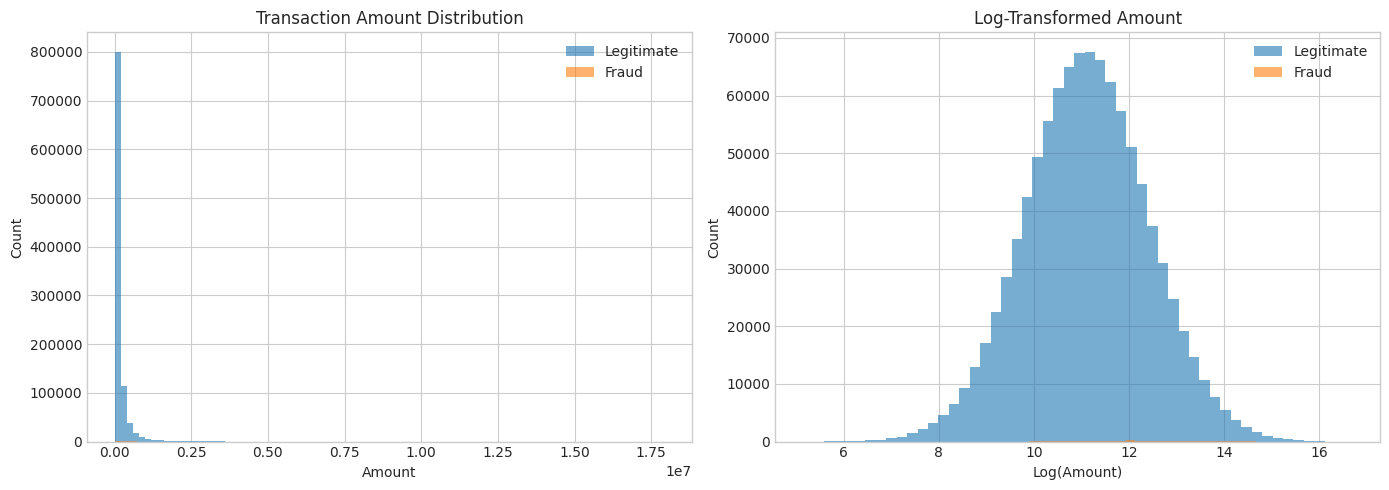

In [5]:
# amount distribution by fraud status
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# histogram
for fraud in [0, 1]:
    label = 'Fraud' if fraud else 'Legitimate'
    axes[0].hist(df[df['is_fraud'] == fraud]['amount'], bins=50, alpha=0.6, label=label)
axes[0].set_xlabel('Amount')
axes[0].set_ylabel('Count')
axes[0].set_title('Transaction Amount Distribution')
axes[0].legend()

# log scale
for fraud in [0, 1]:
    label = 'Fraud' if fraud else 'Legitimate'
    axes[1].hist(np.log1p(df[df['is_fraud'] == fraud]['amount']), bins=50, alpha=0.6, label=label)
axes[1].set_xlabel('Log(Amount)')
axes[1].set_ylabel('Count')
axes[1].set_title('Log-Transformed Amount')
axes[1].legend()

plt.tight_layout()
plt.savefig('./plots/amount_distribution.png', dpi=150)
plt.show()

In [6]:
# fraud by channel
channel_fraud = df.groupby('channel').agg({
    'is_fraud': ['sum', 'mean', 'count']
}).round(4)
channel_fraud.columns = ['fraud_count', 'fraud_rate', 'total']
channel_fraud = channel_fraud.sort_values('fraud_rate', ascending=False)
print(channel_fraud)

         fraud_count  fraud_rate   total
channel                                 
Web              687      0.0034  200488
Mobile          1496      0.0033  449522
POS              551      0.0031  180035
IB               168      0.0017   99653
ECOM              76      0.0015   50227
ATM               22      0.0011   20075


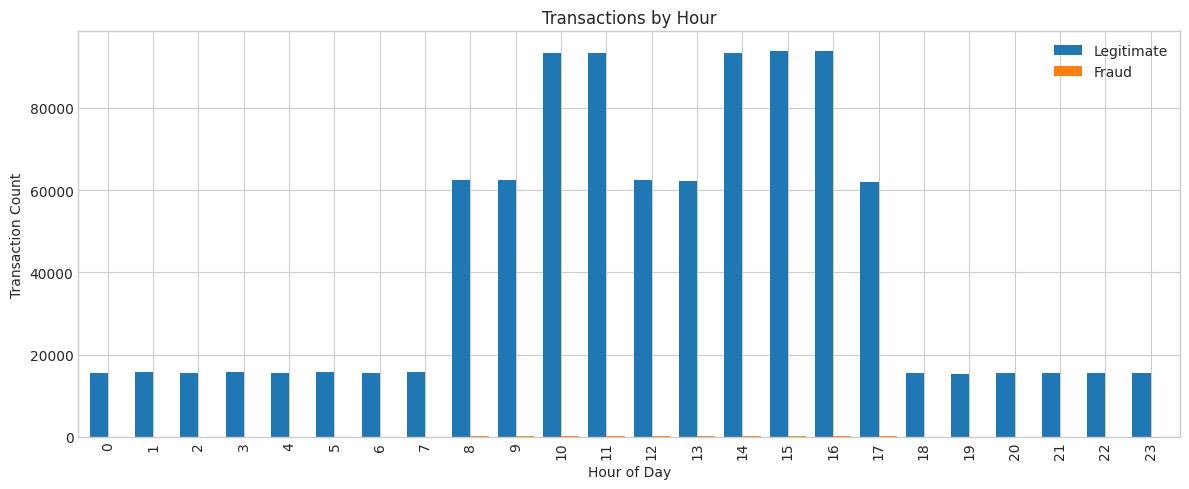

In [7]:
# hourly pattern
df['hour'] = df['timestamp'].dt.hour
hourly = df.groupby(['hour', 'is_fraud']).size().unstack(fill_value=0)

fig, ax = plt.subplots(figsize=(12, 5))
hourly.plot(kind='bar', ax=ax, width=0.8)
ax.set_xlabel('Hour of Day')
ax.set_ylabel('Transaction Count')
ax.set_title('Transactions by Hour')
ax.legend(['Legitimate', 'Fraud'])
plt.tight_layout()
plt.savefig('./plots/hourly_pattern.png', dpi=150)
plt.show()

In [8]:
# fraud technique distribution (for labeled fraud cases)
if 'fraud_technique' in df.columns:
    fraud_df = df[df['is_fraud'] == 1]
    technique_dist = fraud_df['fraud_technique'].value_counts()
    print("Fraud Technique Distribution:")
    print(technique_dist)

Fraud Technique Distribution:
fraud_technique
SOCIAL_ENGINEERING    1929
ROBBERY                341
OTHER                  220
CARD_THEFT             220
PIN_COMPROMISE         158
PHISHING               132
Name: count, dtype: int64


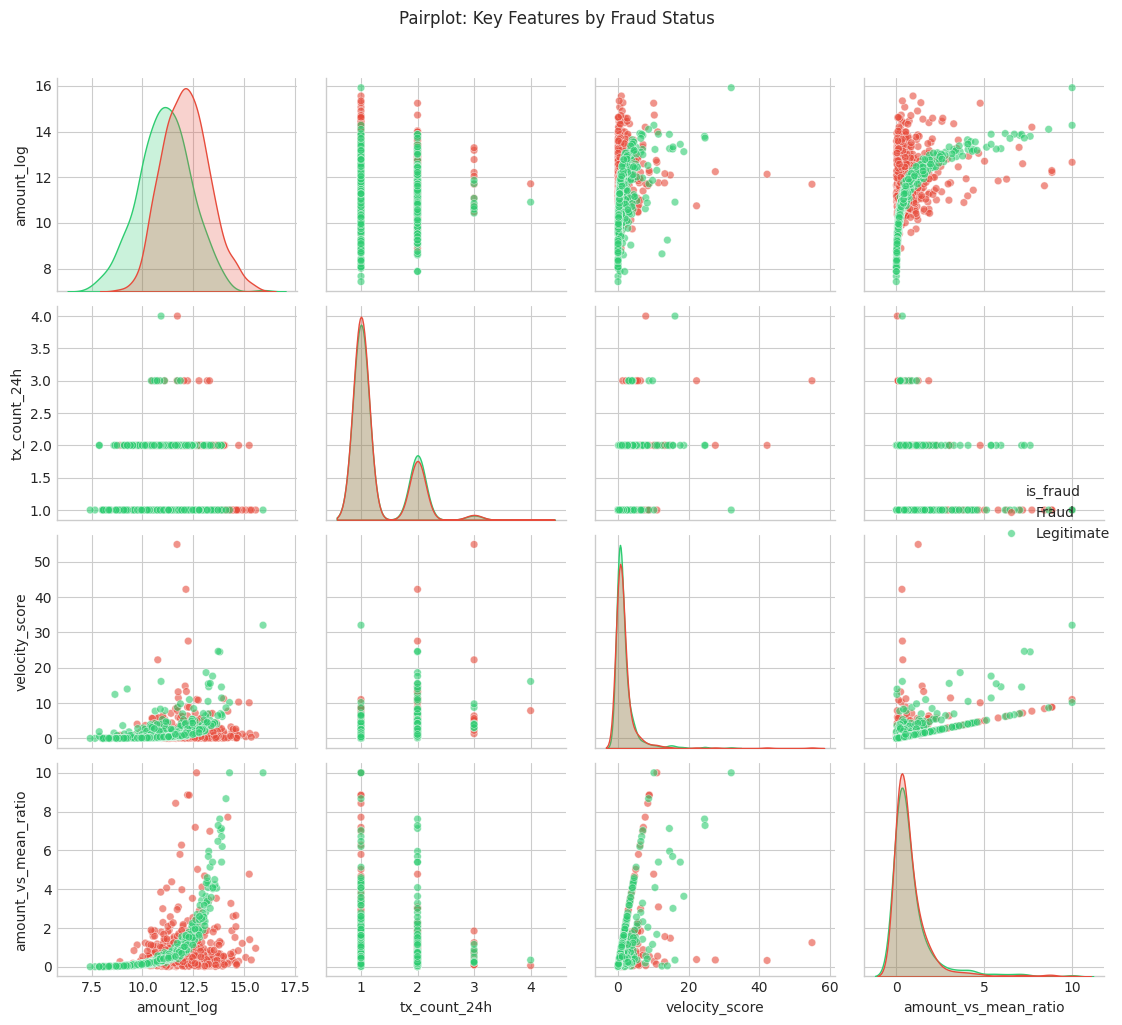

In [9]:
# Pairplot: Key features colored by fraud status
sample_fraud = df[df['is_fraud'] == 1].sample(min(500, len(df[df['is_fraud']==1])), random_state=42)
sample_legit = df[df['is_fraud'] == 0].sample(500, random_state=42)
sample_df = pd.concat([sample_fraud, sample_legit])

plot_cols = ['amount_log', 'tx_count_24h', 'velocity_score', 'amount_vs_mean_ratio', 'is_fraud']
sample_plot = sample_df[plot_cols].copy()
sample_plot['amount_vs_mean_ratio'] = sample_plot['amount_vs_mean_ratio'].clip(0, 10)
sample_plot['is_fraud'] = sample_plot['is_fraud'].map({0: 'Legitimate', 1: 'Fraud'})

g = sns.pairplot(sample_plot, hue='is_fraud', palette={'Legitimate': '#2ecc71', 'Fraud': '#e74c3c'},
                 diag_kind='kde', plot_kws={'alpha': 0.6, 's': 30})
g.fig.suptitle('Pairplot: Key Features by Fraud Status', y=1.02)

plt.tight_layout()
plt.savefig('./plots/pairplot_fraud.png', dpi=150, bbox_inches='tight')
plt.show()

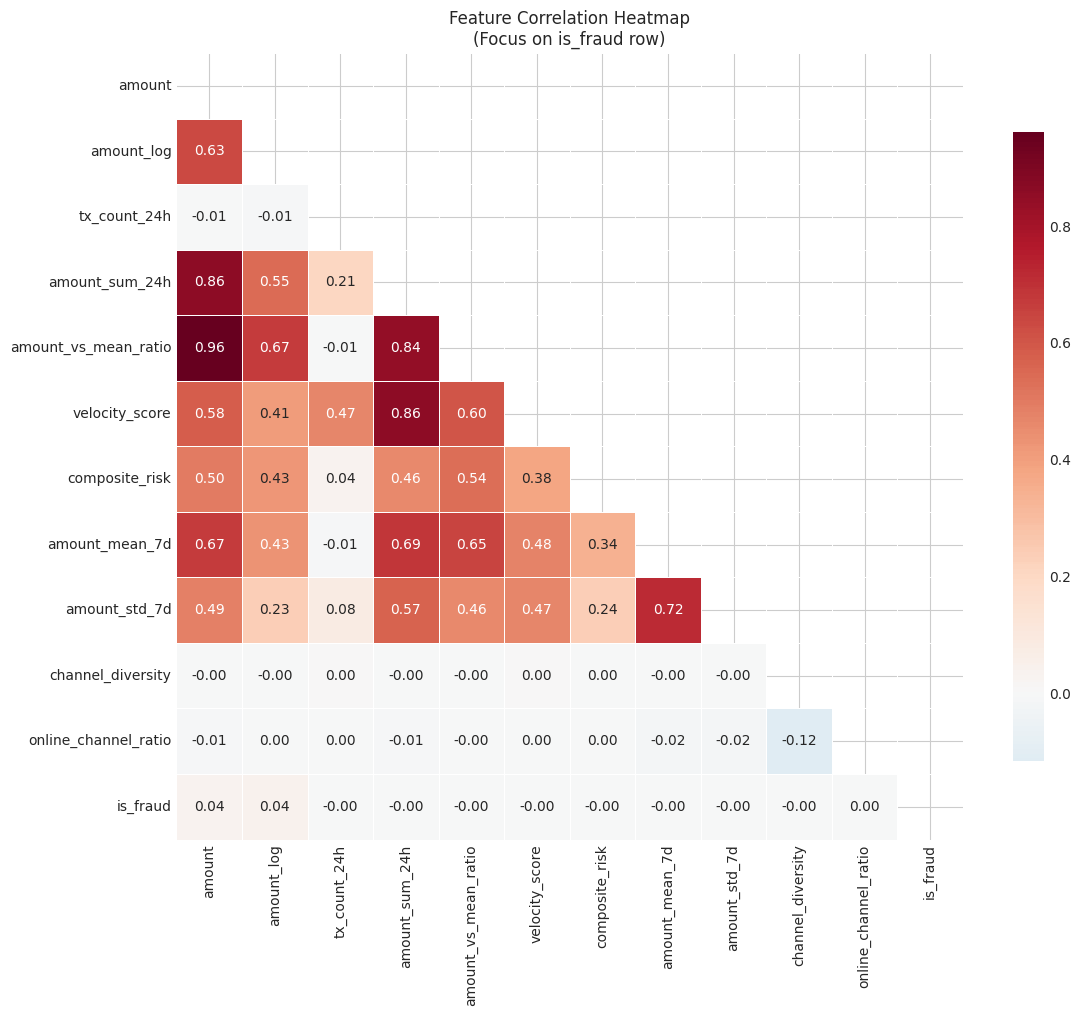


Correlation with Fraud (is_fraud):
  amount_log: 0.0445
  amount: 0.0383
  amount_mean_7d: -0.0025
  amount_std_7d: -0.0025
  amount_vs_mean_ratio: -0.0024
  composite_risk: -0.0019
  velocity_score: -0.0019
  amount_sum_24h: -0.0019
  online_channel_ratio: 0.0013
  tx_count_24h: -0.0011
  channel_diversity: -0.0008


In [10]:
# Multivariate: Correlation Heatmap
numeric_cols = ['amount', 'amount_log', 'tx_count_24h', 'amount_sum_24h', 
                'amount_vs_mean_ratio', 'velocity_score', 'composite_risk',
                'amount_mean_7d', 'amount_std_7d', 'channel_diversity',
                'online_channel_ratio', 'is_fraud']

corr_matrix = df[numeric_cols].corr()

fig, ax = plt.subplots(figsize=(12, 10))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(corr_matrix, mask=mask, annot=True, fmt='.2f', cmap='RdBu_r', 
            center=0, square=True, linewidths=0.5, ax=ax,
            cbar_kws={'shrink': 0.8})
ax.set_title('Feature Correlation Heatmap\n(Focus on is_fraud row)')

plt.tight_layout()
plt.savefig('./plots/correlation_heatmap.png', dpi=150, bbox_inches='tight')
plt.show()

# Print correlations with fraud
print("\nCorrelation with Fraud (is_fraud):")
fraud_corr = corr_matrix['is_fraud'].drop('is_fraud').sort_values(key=abs, ascending=False)
for feat, corr in fraud_corr.items():
    print(f"  {feat}: {corr:.4f}")

### 2.1 Multivariate Analysis

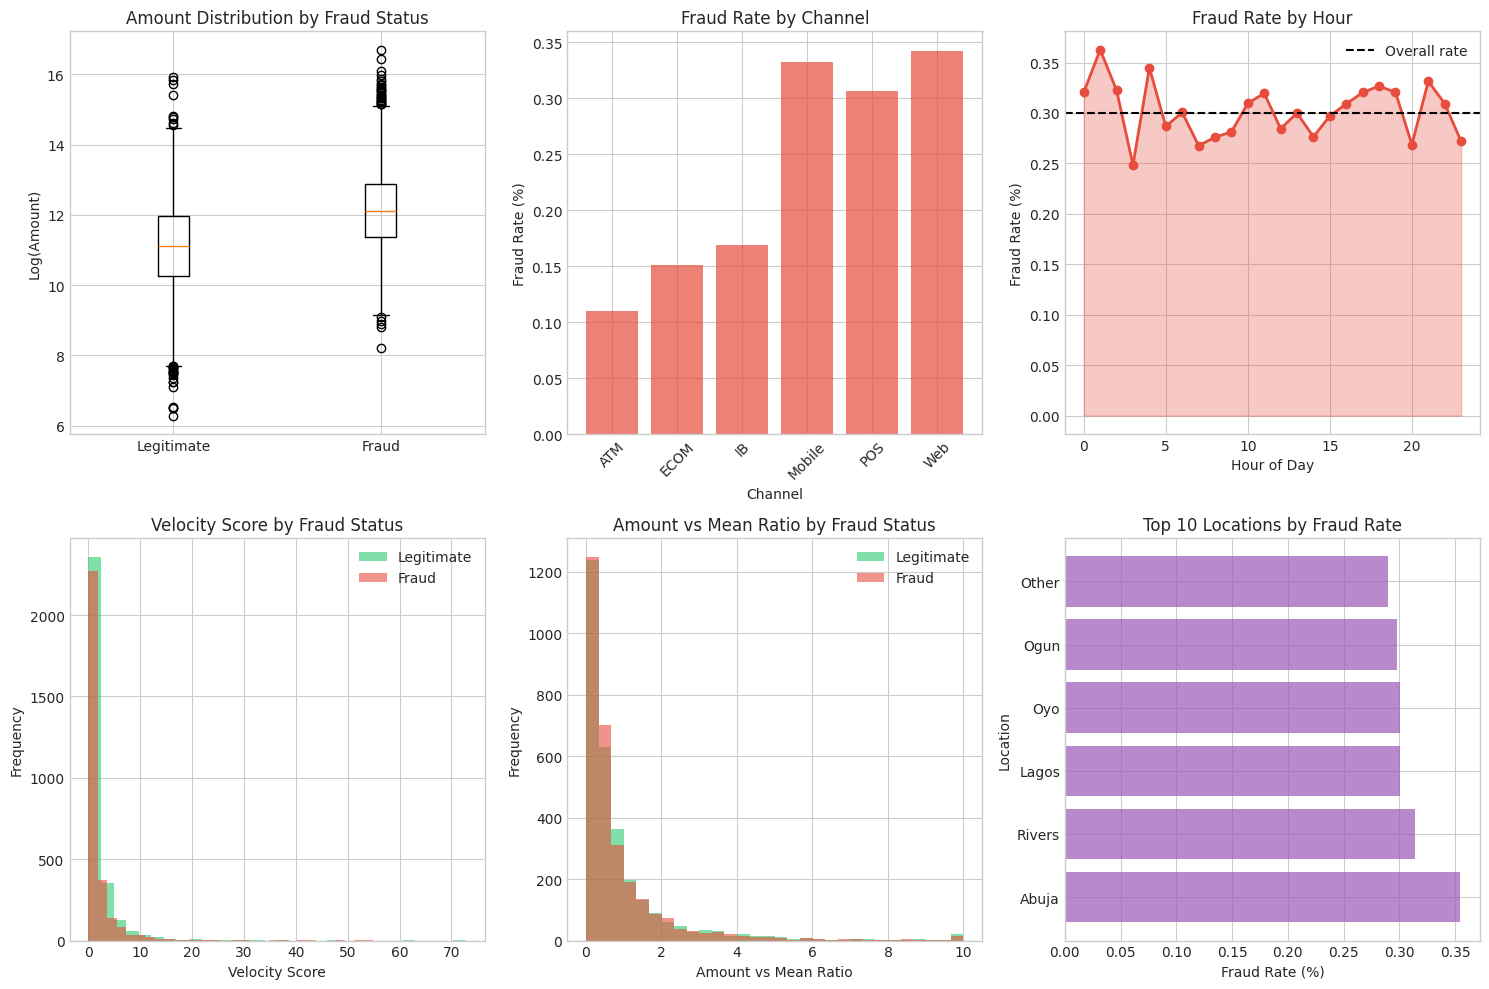

In [11]:
# Bivariate: Features vs Fraud
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# 1. Amount by fraud status (boxplot)
fraud_df = df[df['is_fraud'] == 1]
legit_df = df[df['is_fraud'] == 0].sample(3000, random_state=42)  # sample for visibility
combined = pd.concat([fraud_df, legit_df])

axes[0, 0].boxplot([np.log1p(legit_df['amount']), np.log1p(fraud_df['amount'])], 
                    labels=['Legitimate', 'Fraud'])
axes[0, 0].set_ylabel('Log(Amount)')
axes[0, 0].set_title('Amount Distribution by Fraud Status')

# 2. Fraud rate by channel
channel_fraud_rate = df.groupby('channel')['is_fraud'].mean() * 100
axes[0, 1].bar(channel_fraud_rate.index, channel_fraud_rate.values, color='#e74c3c', alpha=0.7)
axes[0, 1].set_xlabel('Channel')
axes[0, 1].set_ylabel('Fraud Rate (%)')
axes[0, 1].set_title('Fraud Rate by Channel')
axes[0, 1].tick_params(axis='x', rotation=45)

# 3. Fraud rate by hour
hourly_fraud = df.groupby('hour')['is_fraud'].mean() * 100
axes[0, 2].plot(hourly_fraud.index, hourly_fraud.values, 'o-', color='#e74c3c', linewidth=2)
axes[0, 2].fill_between(hourly_fraud.index, hourly_fraud.values, alpha=0.3, color='#e74c3c')
axes[0, 2].set_xlabel('Hour of Day')
axes[0, 2].set_ylabel('Fraud Rate (%)')
axes[0, 2].set_title('Fraud Rate by Hour')
axes[0, 2].axhline(y=df['is_fraud'].mean()*100, color='black', linestyle='--', label='Overall rate')
axes[0, 2].legend()

# 4. Velocity score by fraud status
axes[1, 0].hist(legit_df['velocity_score'], bins=30, alpha=0.6, label='Legitimate', color='#2ecc71')
axes[1, 0].hist(fraud_df['velocity_score'], bins=30, alpha=0.6, label='Fraud', color='#e74c3c')
axes[1, 0].set_xlabel('Velocity Score')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].set_title('Velocity Score by Fraud Status')
axes[1, 0].legend()

# 5. Amount vs mean ratio by fraud status
axes[1, 1].hist(legit_df['amount_vs_mean_ratio'].clip(0, 10), bins=30, alpha=0.6, label='Legitimate', color='#2ecc71')
axes[1, 1].hist(fraud_df['amount_vs_mean_ratio'].clip(0, 10), bins=30, alpha=0.6, label='Fraud', color='#e74c3c')
axes[1, 1].set_xlabel('Amount vs Mean Ratio')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].set_title('Amount vs Mean Ratio by Fraud Status')
axes[1, 1].legend()

# 6. Fraud rate by location (top 10)
location_fraud = df.groupby('location').agg({'is_fraud': ['sum', 'mean', 'count']})
location_fraud.columns = ['fraud_count', 'fraud_rate', 'total']
location_fraud = location_fraud[location_fraud['total'] > 1000].sort_values('fraud_rate', ascending=False).head(10)
axes[1, 2].barh(location_fraud.index, location_fraud['fraud_rate'] * 100, color='#9b59b6', alpha=0.7)
axes[1, 2].set_xlabel('Fraud Rate (%)')
axes[1, 2].set_ylabel('Location')
axes[1, 2].set_title('Top 10 Locations by Fraud Rate')

plt.tight_layout()
plt.savefig('./plots/bivariate_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

### 2.2 Bivariate Analysis (Feature vs Fraud)

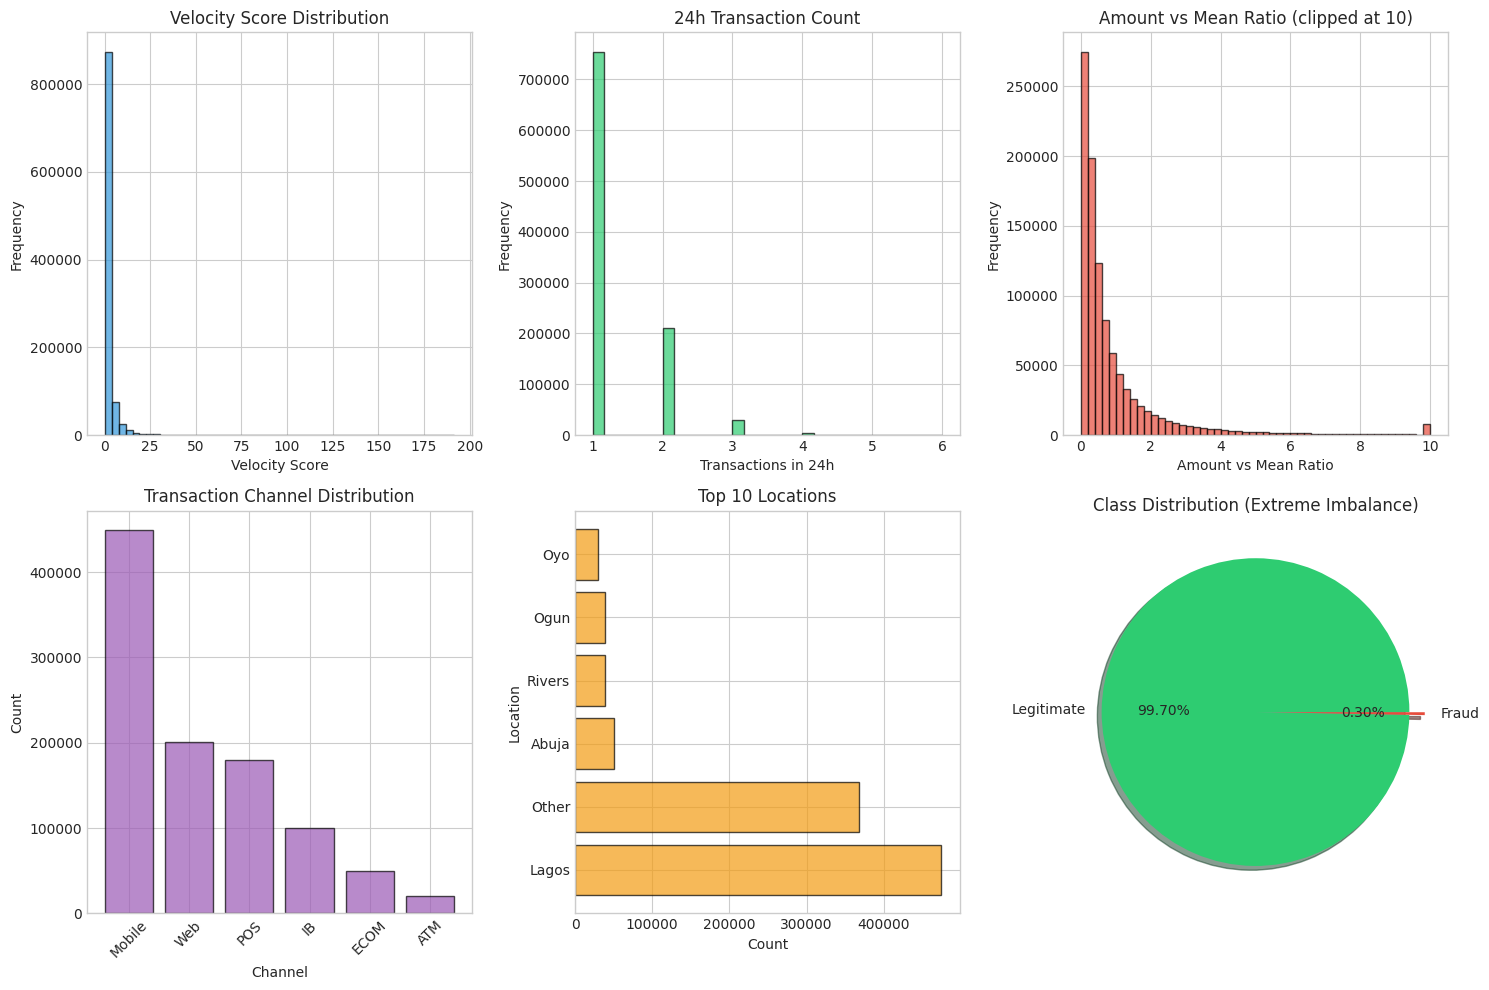

In [12]:
# Univariate: Key feature distributions
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# 1. Velocity score distribution
axes[0, 0].hist(df['velocity_score'], bins=50, color='#3498db', alpha=0.7, edgecolor='black')
axes[0, 0].set_xlabel('Velocity Score')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].set_title('Velocity Score Distribution')

# 2. Transaction count (24h)
axes[0, 1].hist(df['tx_count_24h'], bins=30, color='#2ecc71', alpha=0.7, edgecolor='black')
axes[0, 1].set_xlabel('Transactions in 24h')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].set_title('24h Transaction Count')

# 3. Amount vs mean ratio
axes[0, 2].hist(df['amount_vs_mean_ratio'].clip(0, 10), bins=50, color='#e74c3c', alpha=0.7, edgecolor='black')
axes[0, 2].set_xlabel('Amount vs Mean Ratio')
axes[0, 2].set_ylabel('Frequency')
axes[0, 2].set_title('Amount vs Mean Ratio (clipped at 10)')

# 4. Channel distribution
channel_counts = df['channel'].value_counts()
axes[1, 0].bar(channel_counts.index, channel_counts.values, color='#9b59b6', alpha=0.7, edgecolor='black')
axes[1, 0].set_xlabel('Channel')
axes[1, 0].set_ylabel('Count')
axes[1, 0].set_title('Transaction Channel Distribution')
axes[1, 0].tick_params(axis='x', rotation=45)

# 5. Location distribution
location_counts = df['location'].value_counts().head(10)
axes[1, 1].barh(location_counts.index, location_counts.values, color='#f39c12', alpha=0.7, edgecolor='black')
axes[1, 1].set_xlabel('Count')
axes[1, 1].set_ylabel('Location')
axes[1, 1].set_title('Top 10 Locations')

# 6. Fraud distribution (class imbalance)
fraud_counts = df['is_fraud'].value_counts()
colors = ['#2ecc71', '#e74c3c']
axes[1, 2].pie(fraud_counts.values, labels=['Legitimate', 'Fraud'], autopct='%1.2f%%', 
               colors=colors, explode=(0, 0.1), shadow=True)
axes[1, 2].set_title('Class Distribution (Extreme Imbalance)')

plt.tight_layout()
plt.savefig('./plots/univariate_distributions.png', dpi=150, bbox_inches='tight')
plt.show()

## 3. Feature Engineering

Creating 61 NIBSS-compatible features:
- Temporal features (hour, day, month)
- Amount-based features (log, ratios, flags)
- Customer behavior (velocity, aggregates)
- Sequence features (previous transactions)
- Rarity features (unusual patterns)

In [13]:
def engineer_features(df):
    """Create all 61 features for fraud detection."""
    df = df.copy()
    
    # sort by customer and timestamp
    df = df.sort_values(['customer_id', 'timestamp']).reset_index(drop=True)
    
    # === SEQUENCE FEATURES ===
    # Last 3 amounts
    for i in range(1, 4):
        df[f'prev_amount_{i}'] = df.groupby('customer_id')['amount'].shift(i)
    
    # Amount changes
    df['amount_change_1'] = df['amount'] - df['prev_amount_1']
    df['amount_change_ratio'] = df['amount'] / (df['prev_amount_1'] + 1)
    
    # Time gaps (in hours)
    df['prev_timestamp'] = df.groupby('customer_id')['timestamp'].shift(1)
    df['time_gap_hours'] = (df['timestamp'] - df['prev_timestamp']).dt.total_seconds() / 3600
    
    # Last 5 time gaps
    for i in range(1, 6):
        df[f'time_gap_{i}'] = df.groupby('customer_id')['time_gap_hours'].shift(i-1)
    
    # Average time gap
    df['avg_time_gap_last5'] = df[[f'time_gap_{i}' for i in range(1, 6)]].mean(axis=1)
    
    # Previous channels and categories (important for fraud detection!)
    df['prev_channel'] = df.groupby('customer_id')['channel'].shift(1)
    df['prev_merchant_category'] = df.groupby('customer_id')['merchant_category'].shift(1)
    df['same_channel_as_prev'] = (df['channel'] == df['prev_channel']).astype(int)
    df['same_category_as_prev'] = (df['merchant_category'] == df['prev_merchant_category']).astype(int)
    
    # Transaction count in last hour
    df['is_recent_burst'] = (df['time_gap_hours'] < 1).astype(int)
    df['tx_in_last_hour'] = df.groupby('customer_id')['is_recent_burst'].transform(
        lambda x: x.rolling(5, min_periods=1).sum()
    )
    
    # === RARITY FEATURES ===
    customer_total = df.groupby('customer_id').size().reset_index(name='cust_total')
    
    # Category rarity
    cust_cat = df.groupby(['customer_id', 'merchant_category']).size().reset_index(name='cust_cat_count')
    cust_cat = cust_cat.merge(customer_total, on='customer_id')
    cust_cat['category_rarity_for_customer'] = 1 - (cust_cat['cust_cat_count'] / cust_cat['cust_total'])
    df = df.merge(cust_cat[['customer_id', 'merchant_category', 'category_rarity_for_customer']],
                  on=['customer_id', 'merchant_category'], how='left')
    
    # Channel rarity
    cust_chan = df.groupby(['customer_id', 'channel']).size().reset_index(name='cust_chan_count')
    cust_chan = cust_chan.merge(customer_total, on='customer_id')
    cust_chan['channel_rarity_for_customer'] = 1 - (cust_chan['cust_chan_count'] / cust_chan['cust_total'])
    df = df.merge(cust_chan[['customer_id', 'channel', 'channel_rarity_for_customer']],
                  on=['customer_id', 'channel'], how='left')
    
    # Amount bucket rarity
    df['amount_bucket'] = pd.qcut(df['amount'], q=20, labels=False, duplicates='drop')
    cust_bucket = df.groupby(['customer_id', 'amount_bucket']).size().reset_index(name='cust_bucket_count')
    cust_bucket = cust_bucket.merge(customer_total, on='customer_id')
    cust_bucket['amount_bucket_rarity'] = 1 - (cust_bucket['cust_bucket_count'] / cust_bucket['cust_total'])
    df = df.merge(cust_bucket[['customer_id', 'amount_bucket', 'amount_bucket_rarity']],
                  on=['customer_id', 'amount_bucket'], how='left')
    
    df['combined_rarity_score'] = (df['category_rarity_for_customer'] +
                                   df['channel_rarity_for_customer'] +
                                   df['amount_bucket_rarity']) / 3
    
    # === BEHAVIORAL FEATURES ===
    # Amount deviation from rolling mean
    df['amount_rolling_mean_7d'] = df.groupby('customer_id')['amount'].transform(
        lambda x: x.rolling(7, min_periods=1).mean()
    )
    df['amount_deviation_from_rolling'] = (df['amount'] - df['amount_rolling_mean_7d']) / (df['amount_rolling_mean_7d'] + 1)
    
    # Customer max amount features
    df['customer_max_amount'] = df.groupby('customer_id')['amount'].transform('max')
    df['is_customer_max_amount'] = (df['amount'] == df['customer_max_amount']).astype(int)
    df['ratio_to_customer_max'] = df['amount'] / (df['customer_max_amount'] + 1)
    
    # Frequency acceleration
    df['tx_count_7'] = df.groupby('customer_id')['amount'].transform(
        lambda x: x.rolling(7, min_periods=1).count()
    )
    df['tx_count_30'] = df.groupby('customer_id')['amount'].transform(
        lambda x: x.rolling(30, min_periods=1).count()
    )
    df['frequency_acceleration'] = df['tx_count_7'] / (df['tx_count_30'] / 4 + 1)
    
    # Night and high value features
    df['is_night_transaction'] = ((df['hour'] >= 0) & (df['hour'] <= 5)).astype(int)
    amount_95th = df['amount'].quantile(0.95)
    df['is_high_value'] = (df['amount'] >= amount_95th).astype(int)
    df['night_high_value'] = df['is_night_transaction'] * df['is_high_value']
    
    # Encode categoricals
    for col in ['channel', 'merchant_category', 'bank', 'location', 'age_group']:
        le = LabelEncoder()
        df[f'{col}_encoded'] = le.fit_transform(df[col].astype(str))
    
    return df

In [14]:
# apply feature engineering
print("Engineering features...")
df_featured = engineer_features(df)
print(f"Done. Shape: {df_featured.shape}")

Engineering features...


Done. Shape: (1000000, 78)


## 4. Train/Test Split

In [15]:
# temporal split - 80/20
split_idx = int(len(df_featured) * 0.8)
train_df = df_featured.iloc[:split_idx]
test_df = df_featured.iloc[split_idx:]

print(f"Train: {len(train_df):,} ({train_df['is_fraud'].mean()*100:.3f}% fraud)")
print(f"Test: {len(test_df):,} ({test_df['is_fraud'].mean()*100:.3f}% fraud)")

Train: 800,000 (0.301% fraud)
Test: 200,000 (0.294% fraud)


In [16]:
# select features - all 61 features
feature_cols = [
    # Original numeric features
    'amount', 'hour', 'day_of_week', 'month',
    'tx_count_24h', 'amount_sum_24h', 'amount_mean_7d', 'amount_std_7d',
    'tx_count_total', 'amount_mean_total', 'amount_std_total',
    'channel_diversity', 'location_diversity',
    'amount_vs_mean_ratio', 'online_channel_ratio',
    'hour_sin', 'hour_cos', 'day_sin', 'day_cos', 'month_sin', 'month_cos',
    'amount_log', 'velocity_score', 'merchant_risk_score', 'composite_risk',
    
    # Sequence features
    'prev_amount_1', 'prev_amount_2', 'prev_amount_3',
    'amount_change_1', 'amount_change_ratio',
    'time_gap_hours', 'time_gap_1', 'time_gap_2', 'time_gap_3', 'time_gap_4', 'time_gap_5',
    'avg_time_gap_last5',
    'same_channel_as_prev', 'same_category_as_prev',
    'tx_in_last_hour',
    
    # Rarity features
    'category_rarity_for_customer', 'channel_rarity_for_customer',
    'amount_bucket_rarity', 'combined_rarity_score',
    
    # Behavioral features
    'amount_deviation_from_rolling', 'is_customer_max_amount',
    'ratio_to_customer_max', 'frequency_acceleration',
    'is_night_transaction', 'is_high_value', 'night_high_value',
    'tx_count_7', 'tx_count_30', 'is_recent_burst',
    
    # Encoded categoricals
    'channel_encoded', 'merchant_category_encoded', 'bank_encoded',
    'location_encoded', 'age_group_encoded',
    
    # Boolean
    'is_weekend', 'is_peak_hour'
]

# keep only features that exist
feature_cols = [c for c in feature_cols if c in df_featured.columns]
print(f"Features: {len(feature_cols)}")

Features: 61


In [17]:
# extract arrays
X_train = train_df[feature_cols].values
X_test = test_df[feature_cols].values
y_train = train_df['is_fraud'].values
y_test = test_df['is_fraud'].values

# handle nan/inf
X_train = np.nan_to_num(X_train, nan=0, posinf=0, neginf=0)
X_test = np.nan_to_num(X_test, nan=0, posinf=0, neginf=0)

# scale
scaler = RobustScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

print(f"X_train: {X_train.shape}")
print(f"X_test: {X_test.shape}")

X_train: (800000, 61)
X_test: (200000, 61)


In [18]:
# class balance
fraud_count = y_train.sum()
non_fraud = len(y_train) - fraud_count
scale_pos_weight = non_fraud / fraud_count

print(f"Fraud in train: {fraud_count:,}")
print(f"Non-fraud: {non_fraud:,}")
print(f"Scale pos weight: {scale_pos_weight:.1f}")

Fraud in train: 2,412
Non-fraud: 797,588
Scale pos weight: 330.7


In [19]:
# save for other notebooks
processed_data = {
    'X_train': X_train,
    'X_test': X_test,
    'y_train': y_train,
    'y_test': y_test,
    'feature_names': feature_cols,
    'scaler': scaler,
    'scale_pos_weight': scale_pos_weight,
    'train_customer_ids': train_df['customer_id'].values,
    'test_customer_ids': test_df['customer_id'].values,
    'fraud_technique_train': train_df['fraud_technique'].values if 'fraud_technique' in train_df.columns else None,
    'fraud_technique_test': test_df['fraud_technique'].values if 'fraud_technique' in test_df.columns else None,
}

with open('../data/processed_data.pkl', 'wb') as f:
    pickle.dump(processed_data, f)

print("Saved to ../data/processed_data.pkl")

Saved to ../data/processed_data.pkl
